In [1]:
# Import packages we'll need later on in this tutorial
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import math
import plotly.graph_objects as go
from collections import OrderedDict
from matplotlib.lines import Line2D  # Import for creating custom legend markers
import json


# Import BW25 packages
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa
import brightway2 as bw 
from bw2calc import LeastSquaresLCA

In [2]:
from standards import *

In [3]:
save_dir = results_folder('Results')

Folder name Results created


In [4]:
def LCA_initialization(name, db, flows):
    bd.projects.set_current(name)

    bi.bw2setup()
    eidb = bd.Database(db)
    #print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(eidb), len(eidb)))

    # Corrected dictionary comprehension
    procces_keys = {key: None for key in flows}

    size = len(flows)

    for act in eidb:
        for proc in range(size):
            if act['name'] == flows[proc]:
                procces_keys[flows[proc]] = act['code']
                #print(act['name'], act['code'])

    process = []
    key_counter = 0

    for key, item in procces_keys.items():
        #print(item)
        # Locate the specific process
        try:
            process.append(eidb.get(item))
            #print(process[key_counter])
        except KeyError:
            print(f"Process with key '{item}' not found in the database '{eidb}'")
            process = None
        
        key_counter += 1

    products_list = []

    if process:
        for proc in process:
            #print(proc)
            # Loop through the exchanges and filter for products
            for exc in proc.exchanges():
                if exc['type'] == 'production':
                    # Add the product (output) to the list
                    products_list.append(exc.input)


    # Initialize an empty list to store the linked processes
    linked_processes_list = []

    if process:
        for proc in process:
            # Loop through the exchanges and extract linked process keys
            for exc in proc.exchanges():
                # Add the linked process (input) to the list
                linked_processes_list.append(exc.input)

            # Remove duplicates by converting to a set and back to a list
            linked_processes_list = list(set(linked_processes_list))

        # Display the list of linked processes
        proc_keys = {}
        name_keys = {}

        for linked_process in linked_processes_list:
            # Initialize the list for this database if it doesn't exist
            if linked_process[0] not in proc_keys:
                proc_keys[linked_process[0]] = []
                name_keys[linked_process[0]] = []
                #print(linked_process[0])
            # Append the process key to the list
            proc_keys[linked_process[0]].append(linked_process[1])
            name_keys[linked_process[0]].append(linked_process)

    # List all methods containing 'EF v3.1 EN15804'
    all_methods = [m for m in bw.methods if 'EF v3.1 EN15804' in str(m)]

    # Filter out methods that contain "climate change:" in method[1]
    filtered_methods = [method for method in all_methods if "climate change:" not in method[1]]

    # Print the methods that were removed
    removed_methods = [method[1] for method in all_methods if "climate change:" in method[1]]
    # print("Removed methods:")
    # for rm in removed_methods:
    #     print(rm)

    # Optional: Check the length of the filtered list
    #print(f"Total number of methods after filtering: {len(filtered_methods)}")

    impact_category = filtered_methods
    
    plot_x_axis = [0] * len(impact_category)
    for i in range(len(plot_x_axis)):
        plot_x_axis[i] = impact_category[i][1]
        #print(filtered_methods[i][1])

    # Initialize an empty list to store the results
    product_details = {}

    if process:
        for proc in process:
            # Initialize an empty list for the current process to store its product details
            product_details[proc['name']] = []
            # Loop through the exchanges
            for exc in proc.exchanges():
        
                # We're looking for technosphere exchanges, which are the inputs to the process
                #print(exc['type'], exc.input['code'])
                if exc['type'] == 'technosphere':
                    #if  proc['name'] in exc.input['name']:
                    product_details[proc['name']].append({exc.input['name'] : [exc['amount'], exc.input]})
                        #product_details[proc['name']].append({'product': exc.input['name'], 'amount': exc['amount']})

    idx_df = []
    fu_val = []
    p_code = []

    # Print or save the extracted product details
    for process_name, details in product_details.items():
        for detail in range(len(details)):
            for key, item in details[detail].items():
                idx_df.append(key)
                fu_val.append(details[detail][key][0])
                p_code.append(details[detail][key])

    FU_proc = []

    for flow in flows:
        for flow_length in range(len(product_details[flow])):
            for key in product_details[flow][flow_length].keys():
                # for flow in range(len(flows)):
                if flow in key:
                    #print(key)
                    key = key.replace(f'{flow} ', '')
                FU_proc.append(key)

    FU = []
    for key, item in product_details.items():
        for idx in item:
            for n, m in idx.items():
                FU.append({ key: {m[1]:m[0]}})
                #print(m)
    print('Initialization is done')
    return FU, FU_proc, impact_category, plot_x_axis

In [5]:
def life_cycle_impact_assessment(flows, functional_unit, impact_categories, process):
    # Define the dimensions
    n = len(flows)  # number of rows
    m = len(impact_categories)  # number of columns

    df = pd.DataFrame(0, index=flows, columns=impact_categories, dtype=object)  # dtype to handle lists
    calc_count = 1
    row_counter = 0

    for impact in range(m):
        for f in flows:
            df_lst = []
            for func_unit in range(len(functional_unit)):
                for FU_key, FU_item in functional_unit[func_unit].items():
                    if f in FU_key:
                        cat = impact_categories[impact]
                        lca = bw.LCA(FU_item, cat)
                        lca.lci()
                        lca.lcia()
                        df_lst.append([process[func_unit], lca.score])
                        print(f"Calculation {calc_count} of {m*len(functional_unit)}", FU_item, cat[1], lca.score)
                        calc_count += 1
            df.iloc[row_counter, impact] = df_lst

            print(f'{cat[1]} at row {row_counter} col {impact} has been assigned the list {df_lst}')

            if row_counter == 2:
                row_counter = 0
            else:
                row_counter += 1

    return df

In [6]:
# Your name variable should be the name of the project.
name = "RA - Ofir & Stine 1"
db = "Ananas consq"

flows = ['alubox - CONSQ', 'PP sheet sc2 - CONSQ', 'PP sheet sc3 - CONSQ']
flow_legend = ['alubox - CONSQ sc1', 'PP sheet sc2 - CONSQ', 'PP sheet sc3 - CONSQ']

FU, FU_proc, impact_category, plot_x_axis = LCA_initialization(name, db, flows)
df = life_cycle_impact_assessment(flows, FU, impact_category, FU_proc)
df.head()

Biosphere database already present!!! No setup is needed
Initialization is done


In [7]:
file_name = r'Results\Ananas - CONSQ.xlsx'
sheet_name = 'Ananas'

# Convert each cell to a JSON string for all columns
df = df.applymap(lambda x: json.dumps(x) if isinstance(x, list) else x)

# Save to Excel
with pd.ExcelWriter(file_name) as writer:
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=True)

print('DataFrame with nested lists written to Excel successfully.')

NameError: name 'df' is not defined

In [9]:
# Reading from Excel
df1 = pd.read_excel(file_name)

# Convert JSON strings back to lists for all columns
df1 = df1.applymap(lambda x: json.loads(x) if isinstance(x, str) and x.startswith('[') else x)

df1 = df1.set_axis(flows)
df1.columns = impact_category
df1

C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\1722388229.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = df1.applymap(lambda x: json.loads(x) if isinstance(x, str) and x.startswith('[') else x)


,"(EF v3.1 EN15804, acidification, accumulated exceedance (AE))","(EF v3.1 EN15804, climate change, global warming potential (GWP100))","(EF v3.1 EN15804, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe))","(EF v3.1 EN15804, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels)","(EF v3.1 EN15804, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P))","(EF v3.1 EN15804, eutrophication: marine, fraction of nutrients reaching marine end compartment (N))","(EF v3.1 EN15804, eutrophication: terrestrial, accumulated exceedance (AE))","(EF v3.1 EN15804, human toxicity: carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, ionising radiation: human health, human exposure efficiency relative to u235)","(EF v3.1 EN15804, land use, soil quality index)","(EF v3.1 EN15804, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves))","(EF v3.1 EN15804, ozone depletion, ozone depletion potential (ODP))","(EF v3.1 EN15804, particulate matter formation, impact on human health)","(EF v3.1 EN15804, photochemical oxidant formation: human health, tropospheric ozone concentration increase)","(EF v3.1 EN15804, water use, user deprivation potential (deprivation-weighted water consumption))"
alubox - APOS,"[[alubox raw materials - APOS, 0.0007250559021...","[[alubox raw materials - APOS, 0.1086125966374...","[[alubox raw materials - APOS, 0.3730026082595...","[[alubox raw materials - APOS, 1.0556518609315...","[[alubox raw materials - APOS, 3.5032770614894...","[[alubox raw materials - APOS, 0.0001195552433...","[[alubox raw materials - APOS, 0.0012413197649...","[[alubox raw materials - APOS, 3.0932797627716...","[[alubox raw materials - APOS, 2.1056697858162...","[[alubox raw materials - APOS, 0.0023732065079...","[[alubox raw materials - APOS, 0.2226243967424...","[[alubox raw materials - APOS, 3.4251767857007...","[[alubox raw materials - APOS, 1.1550806945709...","[[alubox raw materials - APOS, 9.1586712615620...","[[alubox raw materials - APOS, 0.0003899683190...","[[alubox raw materials - APOS, 0.0285227927589..."
PP sheet sc2 - APOS,"[[pp production - APOS, 0.0011963049548000416]...","[[pp production - APOS, 0.26461488322163457], ...","[[pp production - APOS, 0.7722809171146071], [...","[[pp production - APOS, 7.493312314065771], [a...","[[pp production - APOS, 5.8697955864900236e-05...","[[pp production - APOS, 0.00024629003122677516...","[[pp production - APOS, 0.0025625177823764395]...","[[pp production - APOS, 9.046424546362439e-11]...","[[pp production - APOS, 2.075388098539777e-09]...","[[pp production - APOS, 0.012754863024139787],...","[[pp production - APOS, 0.4961915426351359], [...","[[pp production - APOS, 1.2043273813471151e-06...","[[pp production - APOS, 3.130819763297311e-09]...","[[pp production - APOS, 1.200679843013133e-08]...","[[pp production - APOS, 0.0009674230895364117]...","[[pp production - APOS, 0.08416777016280644], ..."
PP sheet sc3 - APOS,"[[pp production - APOS, 0.0011963049548000416]...","[[pp production - APOS, 0.26461488322163457], ...","[[pp production - APOS, 0.7722809171146071], [...","[[pp production - APOS, 7.493312314065771], [a...","[[pp production - APOS, 5.8697955864900236e-05...","[[pp production - APOS, 0.00024629003122677516...","[[pp production - APOS, 0.0025625177823764395]...","[[pp production - APOS, 9.046424546362439e-11]...","[[pp production - APOS, 2.075388098539777e-09]...","[[pp production - APOS, 0.012754863024139787],...","[[pp production - APOS, 0.4961915426351359], [...","[[pp production - APOS, 1.2043273813471151e-06...","[[pp production - APOS, 3.130819763297311e-09]...","[[pp production - APOS, 1.200679843013133e-08]...","[[pp production - APOS, 0.0009674230895364117]...","[[pp production - APOS, 0.08416777016280644], ..."


In [10]:
# if 'sc3' in df.iloc[1][0][0][0]:
#     df_updated = swap_rows(df, 2, 1)
# else:
#     df_updated = df.copy()
df_updated = df1.copy()


In [11]:
df_updated.iloc[0,0]

[['alubox raw materials - APOS', 0.0007250559021144519],
 ['alubox production - APOS', 0.00010775102898513805],
 ['autoclave - APOS', 0.001975248208189929],
 ['disinfection - APOS', 0.0017874616449151674],
 ['Handwash - APOS', 0.00014020424747978135],
 ['alubox EoL melting - APOS', -3.542035130514362e-05],
 ['alubox EoL mixed sorting - APOS', 1.523285419517577e-06],
 ['transport Alu - APOS', 6.115378434681468e-06]]

In [12]:
df_tot = df_updated.copy()

for col in range(df_updated.shape[1]):  # Iterate over columns
    for row in range(df_updated.shape[0]):  # Iterate over rows
        tot = 0
        for i in range(len(df_updated.iloc[row,col])):
            #print(df_updated.iloc[row,col][i][1])
            tot += df_updated.iloc[row,col][i][1]
        df_tot.iloc[row,col] = tot
        # print('New row')
df_tot

,"(EF v3.1 EN15804, acidification, accumulated exceedance (AE))","(EF v3.1 EN15804, climate change, global warming potential (GWP100))","(EF v3.1 EN15804, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe))","(EF v3.1 EN15804, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels)","(EF v3.1 EN15804, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P))","(EF v3.1 EN15804, eutrophication: marine, fraction of nutrients reaching marine end compartment (N))","(EF v3.1 EN15804, eutrophication: terrestrial, accumulated exceedance (AE))","(EF v3.1 EN15804, human toxicity: carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh))","(EF v3.1 EN15804, ionising radiation: human health, human exposure efficiency relative to u235)","(EF v3.1 EN15804, land use, soil quality index)","(EF v3.1 EN15804, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves))","(EF v3.1 EN15804, ozone depletion, ozone depletion potential (ODP))","(EF v3.1 EN15804, particulate matter formation, impact on human health)","(EF v3.1 EN15804, photochemical oxidant formation: human health, tropospheric ozone concentration increase)","(EF v3.1 EN15804, water use, user deprivation potential (deprivation-weighted water consumption))"
alubox - APOS,0.004708,1.502969,6.081212,18.47017,0.001009,0.001687,0.012305,0.0,0.0,0.346278,22.609597,0.000006,0.0,0.0,0.003157,0.831915
PP sheet sc2 - APOS,0.004013,1.265038,3.711697,23.059783,0.000448,0.001165,0.010704,0.0,0.0,0.169083,5.966927,0.000005,0.0,0.0,0.003429,0.493635
PP sheet sc3 - APOS,0.003928,1.154422,3.623924,20.534196,0.000458,0.001173,0.010822,0.0,0.0,0.17804,9.106264,0.000005,0.0,0.0,0.003349,0.486399


In [13]:
df_cols = df_tot.columns
df_cols = df_cols.to_list()

df_norm = pd.DataFrame().reindex_like(df_tot) #https://stackoverflow.com/questions/23195250/create-empty-dataframe-with-same-dimensions-as-another
for i in df_cols:
    scaling_factor = max(abs(df_tot[i]))
    for j in range(len(df_tot[df_cols[0]])):
        df_norm[i][j] =df_tot[i][j]/scaling_factor
        #print(scaling_factor, i)
# for j in range(len(data['Index'])):
#     df_norm['Index'][j] = df['Index'][j]


# Selecting the columns from 1th column onwards
columns_to_plot = df_norm.columns
df_cols

C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\3891263138.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_norm[i][j] =df_tot[i][j]/scaling_factor
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\3891263138.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the ass

[('EF v3.1 EN15804', 'acidification', 'accumulated exceedance (AE)'),
 ('EF v3.1 EN15804', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.1 EN15804',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('EF v3.1 EN15804',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('EF v3.1 EN15804',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartment (P)'),
 ('EF v3.1 EN15804',
  'eutrophication: marine',
  'fraction of nutrients reaching marine end compartment (N)'),
 ('EF v3.1 EN15804',
  'eutrophication: terrestrial',
  'accumulated exceedance (AE)'),
 ('EF v3.1 EN15804',
  'human toxicity: carcinogenic',
  'comparative toxic unit for human (CTUh)'),
 ('EF v3.1 EN15804',
  'human toxicity: non-carcinogenic',
  'comparative toxic unit for human (CTUh)'),
 ('EF v3.1 EN15804',
  'ionising radiation: human health',
  'human exposure efficiency relative to u235'),
 ('E

In [16]:
index_list = list(df1.index.values)
index_list

['alubox - APOS', 'PP sheet sc2 - APOS', 'PP sheet sc3 - APOS']

In [17]:
plot_x_axis = [0] * len(impact_category)
for i in range(len(plot_x_axis)):
    if "photochemical oxidant formation" in impact_category[i][1]:
        plot_x_axis[i] = "photochemical oxidant formation"
    else:
        plot_x_axis[i] = impact_category[i][1]
    print(plot_x_axis[i])

acidification
climate change
ecotoxicity: freshwater
energy resources: non-renewable
eutrophication: freshwater
eutrophication: marine
eutrophication: terrestrial
human toxicity: carcinogenic
human toxicity: non-carcinogenic
ionising radiation: human health
land use
material resources: metals/minerals
ozone depletion
particulate matter formation
photochemical oxidant formation
water use


In [18]:
df_GWP = df_updated[df_updated.columns[1]].to_frame()
df_GWP

,EF v3.1 EN15804
,climate change
,global warming potential (GWP100)
alubox - APOS,"[[alubox raw materials - APOS, 0.1086125966374..."
PP sheet sc2 - APOS,"[[pp production - APOS, 0.26461488322163457], ..."
PP sheet sc3 - APOS,"[[pp production - APOS, 0.26461488322163457], ..."


In [77]:
x_axis = []
GWP_value = []

# gwp_tot = [0] * len(df_updated)
for df_size in range(len(df_GWP)):
    lst_x = []
    lst_GWP = []
    gwp_tot = 0
    for key in df_GWP.keys():
        for lst_size in range(len(df_GWP[key][df_size])):
            #print(df_size, lst_size)
            x = df_GWP[key][df_size][lst_size][0]
            gwp = df_GWP[key][df_size][lst_size][1]
            
            #print(gwp,x)
            if '- CONSQ' in x:
                #print(key)
                x = x.replace(f' - CONSQ', '')
            if 'alubox' in x:           
                x = x.replace('alubox ', '')
                if 'raw' in x:
                    x = x.replace('raw materials', 'Raw mat.')
                if 'production' in x:
                    x = 'Production'
            if 'Waste' in x:
                x = 'Incineration'
            if 'market for electricity' in x:
                x = 'Avoided electricity'
            if 'heating' in x:
                x = 'Avoided heat'
            if 'market for polypropylene' in x:
                x = 'PP granulate'
            if 'PE granulate' in x:
                x = 'PE granulate'
            if 'no Energy Recovery' in x:
                x = x.replace(' no Energy Recovery', '')
            if 'board box' in x:
                x = 'Cardboard box'
            if 'packaging film' in x:
                x = 'PE packaging film prod.'
            if 'pp' in x:
                x = x.replace('pp', 'PP')
            if 'autoclave' in x:
                x = x.replace('autoclave', 'Autoclave')
            if 'transport' in x:
                x = 'Transport'

            lst_x.append(x)
            lst_GWP.append(gwp)
            gwp_tot += gwp
    lst_GWP.append(gwp_tot)
    lst_x.append('Total')
    x_axis.append(lst_x)
    GWP_value.append(lst_GWP)

GWP_value[0]

C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\2254457206.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for lst_size in range(len(df_GWP[key][df_size])):
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\2254457206.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df_GWP[key][df_size][lst_size][0]
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\2254457206.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gwp

[0.10861259663740233,
 0.022527579026331034,
 0.7082072487593414,
 0.6424532589677923,
 0.023032886446425434,
 -0.004142427331517011,
 0.0001359257510550435,
 0.0021416451763865488,
 1.5029687134332173]

In [48]:
x_axis

[['Raw mat.',
  'Production',
  'Autoclave',
  'disinfection',
  'Handwash',
  'EoL melting',
  'EoL mixed sorting',
  'Transport',
  'Total'],
 ['PP production',
  'Autoclave',
  'Cardboard box',
  'PE packaging film prod.',
  'PP granulate',
  'Avoided electricity',
  'Transport',
  'PE incineration',
  'PP incineration',
  'Avoided heat',
  'Total'],
 ['PP production',
  'Autoclave',
  'Cardboard box',
  'PE packaging film prod.',
  'PP granulate',
  'PE granulate',
  'PP granulate',
  'Avoided electricity',
  'Transport',
  'PE incineration',
  'PP incineration',
  'Avoided heat',
  'Total']]

In [64]:
# Categories definitions
categories = ["Raw mat. + prod.", "Use", "Transport", "EoL", "Total"]
category_mapping = {
    "Raw mat. + prod.": ["PP production", "Cardboard box", "Scalpel", "Raw mat.", "Production"],
    "Use": ["Autoclave", "disinfection", "Handwash", "Remanufacturing"],
    "Transport": ["Transport"],
    "EoL": ["Incineration", "Avoided heat", "Avoided electricity", "EoL melting", "EoL mixed sorting"],
    "Total": ["Total"]
}

# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                #print(x_axis[x_lst][x], item, x_axis[x_lst][x] in item)
                if x_axis[x_lst][x] in item:
                    # print(x_axis[x_lst][x], item, x_lst, x)
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            print(val)
            plot_legend[key].append(val)


colors = plot_colors(temp,'turbo')
len(temp)

Raw mat.
Production
PP production
Cardboard box
Autoclave
disinfection
Handwash
Transport
EoL melting
EoL mixed sorting
Avoided electricity
Avoided heat
Total


13

In [65]:
columns_to_plot = df_norm.columns

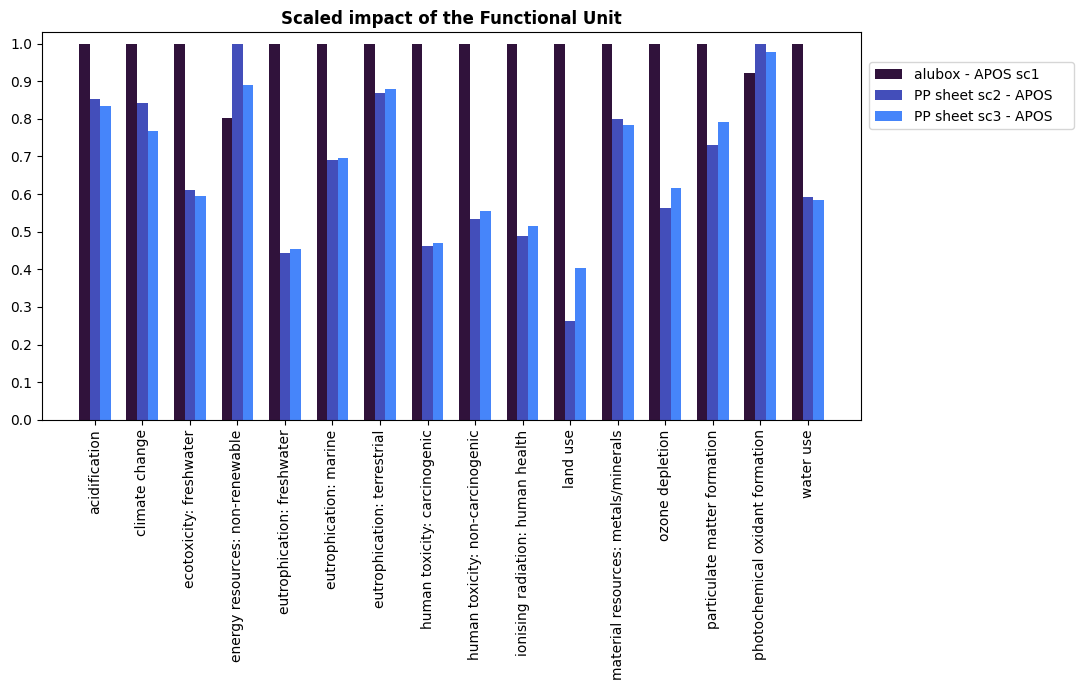

In [66]:


# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_norm)
bar_width = 1/(len(index_list) + 1.5) 
index = np.arange(len(columns_to_plot))



count = 3

# Plotting each group of bars
for i, process in enumerate(df_norm.index):
    values = df_norm.loc[process, columns_to_plot].values
    ax.bar((index + i * bar_width), values, bar_width, label=process, color=colors[i])
    count += 3
    

# Setting labels and title
ax.set_title('Scaled impact of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(plot_x_axis)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

ax.legend(flow_legend,bbox_to_anchor=(1.01, .75, .25, 0), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=1)
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

In [67]:
directory = 'C:\\Users\\ruw\\Desktop\\RA\\'
file = f'{directory}Single-use-vs-multi-use-in-health-care\\Norm + Weigh.xlsx'

data_NW = pd.read_excel(file)


In [68]:
norm_lst = data_NW['Normalization']
weigh_lst = data_NW['Weighting'].to_list
print(len(data_NW['Normalization']))

norm_lst = [0]*(len(data_NW['Normalization']))
weigh_lst = [0]*(len(data_NW['Weighting']))

for i in range(len(data_NW['Normalization'])):
    norm_lst[i] = data_NW['Normalization'][i]
    weigh_lst[i] = data_NW['Weighting'][i]



16


In [69]:
df_cols[2]

('EF v3.1 EN15804',
 'ecotoxicity: freshwater',
 'comparative toxic unit for ecosystems (CTUe)')

In [70]:
norm_df = pd.DataFrame().reindex_like(df1) #https://stackoverflow.com/questions/23195250/create-empty-dataframe-with-same-dimensions-as-another
weigh_df = pd.DataFrame().reindex_like(df1)

counter = 0
for i in df_cols:
    for j in range(len(df_tot[df_cols[0]])):
        norm_df[i][j] =df_tot[i][j] * norm_lst[counter]
        weigh_df[i][j] =norm_df[i][j] * weigh_lst[counter]
        #print(i, norm_df[i][j], weigh_df[i][j])
    counter +=1

lst = [0] * len(weigh_df[df_cols[0]])
for j in range(len(weigh_df[df_cols[0]])):
    for i in df_cols:
        lst[j] += weigh_df[i][j]
        #print(i,j)



C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\117652070.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  norm_df[i][j] =df_tot[i][j] * norm_lst[counter]
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\117652070.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the 

In [71]:
lst_scaled = [0] * len(lst)
lst_max = max(lst)


for n in range(len(lst)):
    lst_scaled[n] = lst[n]/lst_max

lst_scaled

[1.0, 0.8124217383900967, 0.7687832431979698]

In [72]:
def LCA_normalization(file, columns, df):
    # file = r'D:\UNI\MILJOETEK\4. semester\Calculations - Copy\LCIA FU_.xlsx'

    # sheet2 = 'Norm + Weigh'

    data_NW = pd.read_excel(file)

    norm_lst = data_NW['Normalization']
    weigh_lst = data_NW['Weighting'].to_list
    #print(len(data_NW['Normalization']))

    norm_lst = [0]*(len(data_NW['Normalization']))
    weigh_lst = [0]*(len(data_NW['Weighting']))

    for i in range(len(data_NW['Normalization'])):
        norm_lst[i] = data_NW['Normalization'][i]
        weigh_lst[i] = data_NW['Weighting'][i]

    norm_df = pd.DataFrame().reindex_like(df) #https://stackoverflow.com/questions/23195250/create-empty-dataframe-with-same-dimensions-as-another
    weigh_df = pd.DataFrame().reindex_like(df)

    counter = 0
    for i in columns:
        for j in range(len(df[columns[0]])):
            norm_df[i][j] =df[i][j] * norm_lst[counter]
            weigh_df[i][j] =norm_df[i][j] * weigh_lst[counter]
            #print(i, norm_df[i][j], weigh_df[i][j])
        counter +=1

    lst = [0] * len(weigh_df[columns[0]])
    for j in range(len(weigh_df[columns[0]])):
        for i in columns:
            lst[j] += weigh_df[i][j]
            #print(i,j)

    lst_norm_weighted = [0] * len(lst)
    lst_max = max(lst)


    for n in range(len(lst)):
        lst_norm_weighted[n] = lst[n]/lst_max

    # lst_scaled
    return lst_norm_weighted

In [73]:
lst_scaled = LCA_normalization(file, df_cols, df_tot)

C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\1116801234.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  norm_df[i][j] =df[i][j] * norm_lst[counter]
C:\Users\ruw\AppData\Local\Temp\8\ipykernel_181176\1116801234.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the 

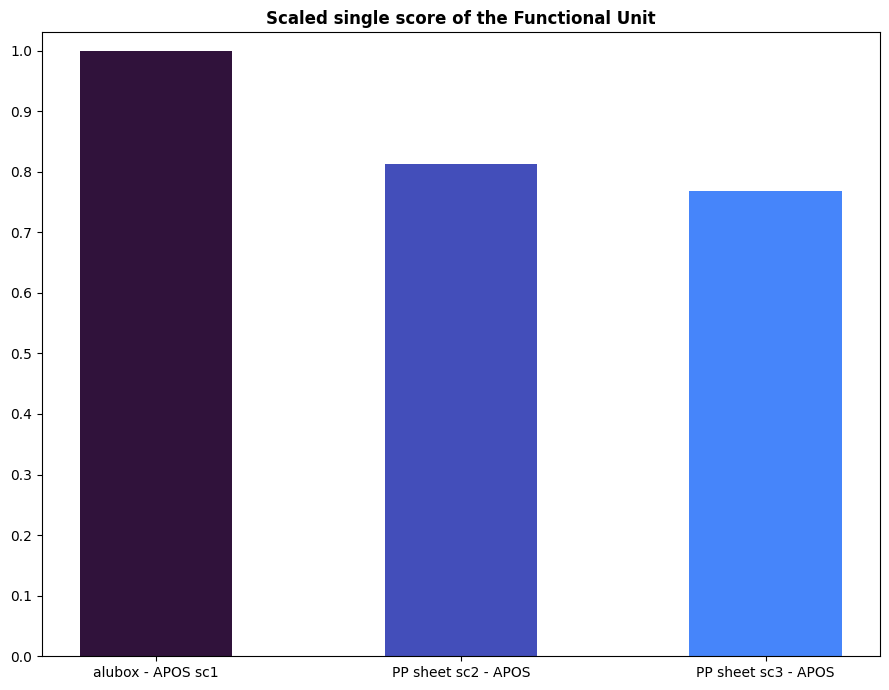

In [74]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_norm)
bar_width = 1/(len(index_list)-5) 
index = np.arange(len(index_list))   

ax.bar(index + bar_width, lst_scaled, bar_width, label=index_list, color=colors)

# Setting labels and title
ax.set_title('Scaled single score of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(flow_legend)
#plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

plt.tight_layout()
# plt.savefig(os.path.join(save_dir, img_res), bbox_inches='tight')
plt.show()

In [75]:
# # Categories definitions
# categories = ["Raw mat. + prod.", "Use", "Transport", "EoL", "Total"]
# category_mapping = {
#     "Raw mat. + prod.": ["Diathermy", "Bipolar burner", "Scalpel"],
#     "Use": ["Autoclave", "Dishwasher", "Erbe", "Remanufacturing"],
#     "Transport": ["Transport"],
#     "EoL": ["Incineration", "Avoided heat", "Avoided electricity"],
#     "Total": ["Total"]
# }

# # Ensure the legend displays items in the category order
# ordered_legend = {key: [] for key in category_mapping}

# for x_lst in range(len(x_axis)):
#     for x in range(len(x_axis[x_lst])):
        
#         for key, item in category_mapping.items():
#                 #print(x_axis[x_lst][x], item, x_axis[x_lst][x] in item)
#                 if x_axis[x_lst][x] in item:
#                     # print(x_axis[x_lst][x], item, x_lst, x)
#                     ordered_legend[key].append(x_axis[x_lst][x])

# plot_legend = {key: [] for key in category_mapping}
# temp = []

# for key,value in ordered_legend.items():
#     #print(key, value)
#     for val in value:
#         if val not in temp:
#             temp.append(val)
#             print(val)
#             plot_legend[key].append(val)




# temp

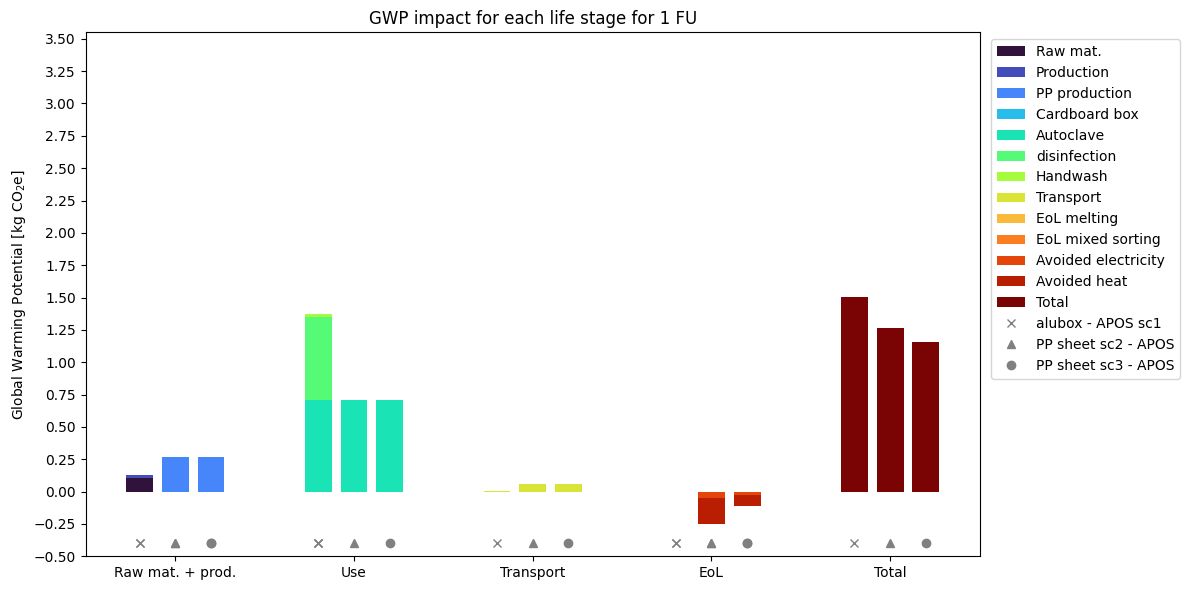

In [76]:

color_map = {}
#unique_processes = {process for sublist in x_axis for process in sublist}
for i, process in enumerate(temp):
    color_map[process] = colors[i]
    #print(process, i)



# Initialize an ordered dictionary for legend_handles to maintain the order
legend_handles = OrderedDict()

# Initialize legend_handles with keys from plot_legend and empty lists
for process in temp:
    legend_handles[process] = None

# Plotting logic
if len(x_axis) == len(GWP_value):
    num_scenarios = len(GWP_value)  # Number of scenarios
    bar_width = 0.15  # Width of the bars for each scenario
    space_between_scenarios = 0.05  # Space between each scenario set
    index = np.arange(len(categories))  # X-axis index positions for the categories

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    idx = ['x', '^', 'o']  # List of markers for scenarios
    all_markers = []  # List to store Line2D objects for markers

    # Main plotting logic
    for scenario in range(num_scenarios):
        bottom_positive = np.zeros(len(categories))  # Initialize the bottom array for positive values
        bottom_negative = np.zeros(len(categories))  # Initialize the bottom array for negative values
        scenario_index = index + scenario * (bar_width + space_between_scenarios)

        for length in range(len(x_axis[scenario])):
            process_name = x_axis[scenario][length]
            value = GWP_value[scenario][length]

            # Determine which category this process falls into
            for i, category in enumerate(categories):
                if any(keyword in process_name for keyword in category_mapping[category]):
                    # Assign color based on the process name
                    color = color_map[process_name]

                    # Create a bar with the specific color
                    if value >= 0:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_positive[i],
                                    color=color)
                        bottom_positive[i] += value
                    else:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_negative[i],
                                    color=color)
                        bottom_negative[i] += value

                    # Add the bar to the corresponding process in legend_handles
                    if legend_handles[process_name] is None:
                        legend_handles[process_name] = bar

                    # Add plot markers (symbols) at the bottom
                    ax.plot(scenario_index[i], -0.4, marker=idx[scenario], color='gray')

                    break

    # Add custom markers to the legend
    for i, marker in enumerate(idx):
        all_markers.append(Line2D([0], [0], marker=marker, color='gray', label=f'Scenario {i + 1}', linestyle='None'))

    # Set x-axis labels and ticks, adjusting to account for spacing
    tick_positions = index + (num_scenarios - 1) * (bar_width + space_between_scenarios) / 2
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(categories)

    # Axis limits
    ax.set_ylim(-.45, 3.55)
    ax.set_yticks(np.arange(-0.5, 3.6, step=0.25))
    ax.set_ylabel("Global Warming Potential [kg CO$_2$e]")
    ax.set_title('GWP impact for each life stage for 1 FU')

    # Add markers to legend_handles for display at the bottom of the legend
    valid_legend_handles = [(k, v) for k, v in legend_handles.items() if v is not None]
    legend_handles_for_display = valid_legend_handles + [(flow_legend[i], marker) for i, marker in enumerate(all_markers)]

    if legend_handles_for_display:
        ax.legend(handles=[v for k, v in legend_handles_for_display], labels=[k for k, v in legend_handles_for_display], bbox_to_anchor=(1.005, 1), loc='upper left')

    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, f'LC_impact_ofir_APOS.jpg'), bbox_inches='tight')
    plt.show()
    

else:
    print('The x-axis and GWP values have different sizes')
